In [1]:
from sklearn.datasets import load_diabetes, load_breast_cancer
from typing import Optional, Tuple
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]
})
import seaborn as sns
sns.set()
cp = sns.color_palette()
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import FrEIA.framework as ff
import FrEIA.modules as fm
from tqdm.notebook import tqdm
from IPython import display
import latent_dp

In [2]:
ds_name = "diabetes"  # "breast_cancer"
exec(f"ds = load_{ds_name}()")
x, y = torch.from_numpy(ds["data"]).cuda().float(), torch.from_numpy(ds["target"])

In [3]:
x = x / x.max(0, keepdim=True)[0]
x.max(dim=0)

torch.return_types.max(
values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0'),
indices=tensor([204,   0, 367, 340, 230, 123,  58, 123,  23,  23], device='cuda:0'))

In [4]:
ds["feature_names"]

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

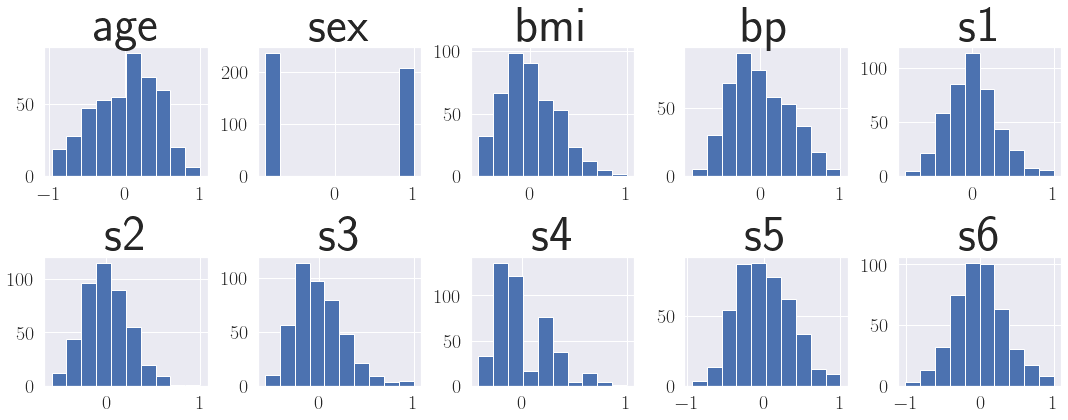

In [5]:
if ds_name == "diabetes":
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
elif ds_name == "breast_cancer":
    fig, axs = plt.subplots(5, 6, figsize=(40,30))
for i, ax in enumerate(axs.flatten()):
    hist, bin_edges = np.histogram(x[:,i].cpu().numpy())#, density=True)
    # hist_rev, _ = np.histogram(rev_dp[:,i].cpu().numpy(), range=(bin_edges.min(), bin_edges.max()), density=True)
    ax.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0], align="edge", label="true")
    # ax.bar(bin_edges[:-1], hist_rev, width=bin_edges[1]-bin_edges[0], align="edge", alpha=0.7, label="dp")
    ax.set_title(ds["feature_names"][i], fontsize=50)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
# ax.legend(fontsize=40, loc="upper center", bbox_to_anchor=(1., 1.15)) #, ncol=2)

fig.tight_layout()
# fig.savefig(f"./experiments/categorical/features_diabetes.pdf", bbox_inches="tight")
plt.show()

In [6]:
n_blocks = 4
n_epochs = 5000
lr = 1e-4
noise_std = 0.02
rev_loss = False # True
register_forward_hook = True
plot_every = 50
coupling_block = fm.GINCouplingBlock # fm.GLOWCouplingBlock

def subnet_fc(dims_in: int, dims_out: int) -> nn.Sequential:
    return nn.Sequential(
        nn.Linear(dims_in, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, dims_out)
    )

In [7]:
nodes = [ff.InputNode(x.size(1), name="inp")]
cond = ff.ConditionNode(1)
for i in range(1, n_blocks + 1):
    nodes.append(ff.Node([nodes[-1].out0], fm.PermuteRandom, {"seed": i}, name=f"permute_{i}"))
    nodes.append(ff.Node([nodes[-1].out0], coupling_block, {"clamp": 2.0, "subnet_constructor": subnet_fc}, conditions=cond, name=f"coupling_{i}"))
nodes.append(ff.OutputNode([nodes[-1].out0], name="out"))
nodes.append(cond)

In [8]:
model = ff.ReversibleGraphNet(nodes, verbose=False).cuda()
# x, y = torch.cuda.FloatTensor(x), torch.cuda.FloatTensor(y)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [31]:
forward_plot_titles = [r"$\mathbf{x}$", *[f"t{i}" for i in range(1, 4)], r"$f_{\theta}(\mathbf{x})$"]
backward_plot_titles = [r"$f_{\theta}(\mathbf{z})$", *[f"t{i}" for i in range(1, 4)], r"$\mathbf{z} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$"]

z = torch.randn(x.shape, device="cuda")

pbar = tqdm(range(n_epochs))
for e in pbar:
    feature_maps = []
    
    optimizer.zero_grad()
    x_noisy = x + torch.randn(x.shape, device=x.device) * noise_std
    if ds_name == "diabetes":
        x[:,1] = (x[:,1] > 0).float()
        cond = (x[:,1:2] > 0).float()
    elif ds_name == "breast_cancer":
        cond = y[:,None].cuda()
    out, jac = model(x_noisy, cond)
    zz = 0.5 * torch.sum(out**2, dim=1)
    nll = zz - jac
    loss = torch.mean(nll)
    loss.backward(retain_graph=rev_loss)
    
    #if rev_loss:
    #    z_noisy = torch.randn((x.size(0), 10), device="cuda")
        # z_noisy = z + torch.randn(x.shape, device=x.device) * noise_std
    #    recon, _ = model(z_noisy, rev=True)
    #    mse = F.mse_loss(recon, x)
    #    mse.backward()
    
    nn.utils.clip_grad_norm_(model.parameters(), 2)
    
    optimizer.step()
    out = out.cpu().detach()
    
    # if i % plot_every == 0:
    pbar.set_description(f"nll: {loss.item():.4f}") # | MSE: {mse.item():.4f}")

  0%|          | 0/500 [00:00<?, ?it/s]

In [70]:
revs_dp = []
for epsilon in [.5, 1., 3.]:
    laplace_dp = latent_dp.LaplaceMechanism(epsilon, .1)
    with torch.no_grad():
        if ds_name == "diabetes":
            cond = (x[:,1:2] > 0).float()
        elif ds_name == "breast_cancer":
            cond = y[:,None].cuda()
        z, _ = model(x, cond)
        # gm_sigma = sigma_gaussian_mechanism(z, epsilon, delta)
        z_dp = laplace_dp(z)
        cond = torch.randint_like(cond, 2)
        # z_dp = z + gm_sigma.cuda() * torch.randn(z.size()).cuda()
        rev_dp, _ = model(z_dp, cond, rev=True)
        rev, _ = model(z, cond, rev=True)
        revs_dp.append(rev_dp)

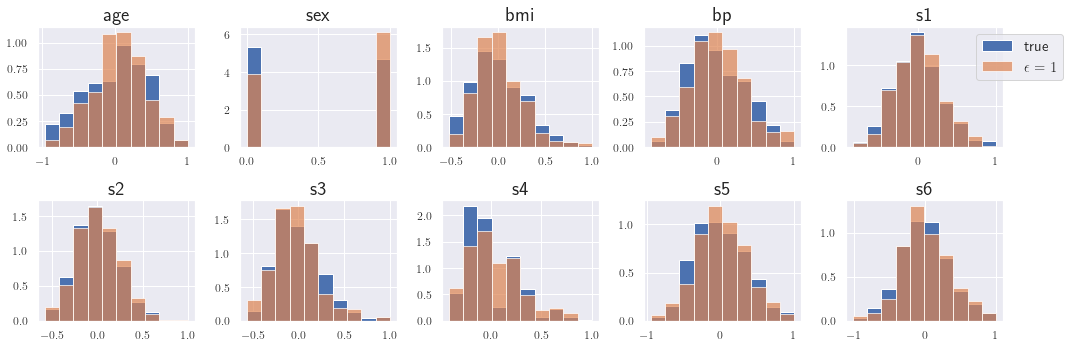

In [71]:
if ds_name == "diabetes":
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
elif ds_name == "breast_cancer":
    fig, axs = plt.subplots(5, 6, figsize=(40,30))
for i, ax in enumerate(axs.flatten()):
    hist, bin_edges = np.histogram(x[:,i].cpu().numpy(), density=True)
    ax.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0], align="edge", label="true")
    for rev_dp, epsilon in zip(revs_dp[1:2], [1]):#revs_dp[::-1], [9, 6, 3]):
        hist_rev, _ = np.histogram(rev_dp[:,i].cpu().numpy(), range=(bin_edges.min(), bin_edges.max()), density=True)
        ax.bar(bin_edges[:-1], hist_rev, width=bin_edges[1]-bin_edges[0], align="edge", alpha=0.7, label=r"$\epsilon = %d$" % int(epsilon))
    ax.set_title(ds["feature_names"][i], fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    #if i == 6:
    #    break
    if i == 4:
        ax.legend(fontsize=15, loc="upper center", bbox_to_anchor=(1.1, 1.)) #, ncol=2)

fig.tight_layout()
#fig.savefig(f"./experiments/categorical/features_{ds_name}.pdf", bbox_inches="tight")
plt.show()

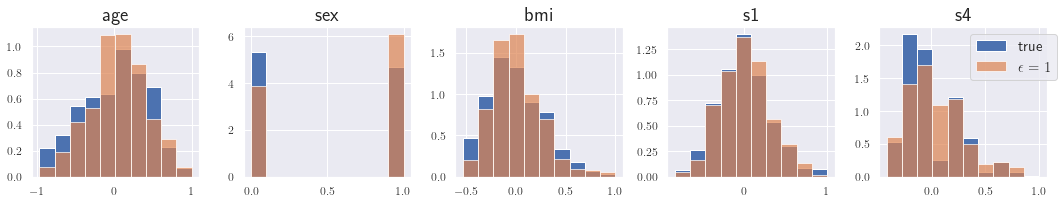

In [75]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
if ds_name == "diabetes":
    idx = [0, 1, 2, 4, 7]
    #idx = [3, 5, 6, 8, 9]
    #x_plot = x.cpu()[:,idx]
    feature_names = np.array(ds["feature_names"])[idx].tolist()
elif ds_name == "breast_cancer":
    fig, axs = plt.subplots(5, 6, figsize=(40,30))
for i, ax in zip(idx, axs.flatten()):
    hist, bin_edges = np.histogram(x[:,i].cpu().numpy(), density=True)
    ax.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0], align="edge", label="true")
    
    for rev_dp, epsilon in zip(revs_dp[1:2], [1]):#revs_dp[::-1], [9, 6, 3]):
        try:
            hist_rev, _ = np.histogram(rev_dp[:,i].cpu().numpy(), range=(bin_edges.min(), bin_edges.max()), density=True)
            ax.bar(bin_edges[:-1], hist_rev, width=bin_edges[1]-bin_edges[0], align="edge", alpha=0.7, label=r"$\epsilon = %d$" % int(epsilon))
        except:
            import pdb;pdb.set_trace()
    ax.set_title(ds["feature_names"][i], fontsize=20)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    #if i == 6:
    #    break
    if i == idx[-1]:
        ax.legend(fontsize=15, loc="upper center", bbox_to_anchor=(.8, 1.)) #, ncol=2)

fig.tight_layout()
fig.savefig(f"./experiments/categorical/features_{ds_name}_example_features.pdf", bbox_inches="tight")
plt.show()